In [47]:
import os

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.distributions as dist
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.nn import PyroModule, PyroSample
from pyro.optim import Adam

from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument, compute_freq
from qubic.lib.MapMaking.FrequencyMapMaking.Qspectra_component import CMBModel
from qubic.lib.MapMaking.NeuralNetworkMapMaking.operators.forward_ops import ForwardOps
from qubic.lib.Qdictionary import qubicDict
from qubic.lib.Qsamplings import get_pointing
from qubic.lib.Qscene import QubicScene

%matplotlib inline

# QUBIC Parameters

In [48]:
dictfilename = "qubic/qubic/dicts/pipeline_demo.dict"
d = qubicDict()
d.read_from_file(dictfilename)

In [49]:
d["nf_recon"] = 1
d["MultiBand"] = False
d["synthbeam_kmax"] = 1
nf_sub = d["nf_sub"]
d["synthbeam_fraction"] = 1
d["noiseless"] = True
d["photon_noise"] = False
d["use_synthbeam_fits_file"] = False
d["npointings"] = 1000
d["nside"] = 128

# Build Sky

(196608, 3)


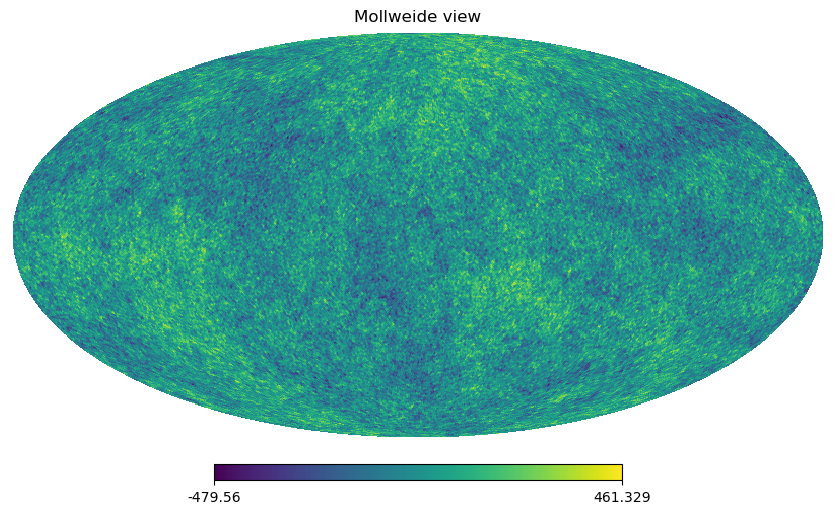

In [50]:
seed = 3
cl_cmb = CMBModel(None).give_cl_cmb(r=0, Alens=1)
sky_map = np.array(d["nf_sub"] * [hp.synfast(cl_cmb, d["nside"], new=True, verbose=False).T])[0]
print(sky_map.shape)

hp.mollview(sky_map[..., 0])

# QUBIC Instance

In [51]:
p = get_pointing(d)
s = QubicScene(d)
q = QubicInstrument(d)
acquisition = QubicAcquisition(q, p, s, d)

_, nus_edge, nus, _, _, _ = compute_freq(d["filter_nu"] / 1e9, d["nf_sub"], d["filter_relative_bandwidth"])

In [52]:
H = acquisition.get_operator()
convolution = acquisition.get_convolution_peak_operator()
convolved_maps = convolution(sky_map)
cov = acquisition.get_coverage()

Info proton: Allocating (992000,9) elements = 136.23046875 MiB in FSRRotation3dMatrix.__init__.
Info proton: Allocating (992000,9) elements = 136.23046875 MiB in FSRRotation3dMatrix.__init__.


In [53]:
forward_ops = ForwardOps(q, acquisition, s)

# Sequential Operators combinations for training

In [54]:
Us = forward_ops.op_unit_conversion()(convolved_maps)

TUs = Us

ATUs = forward_ops.op_aperture_integration()(TUs)

FATUs = forward_ops.op_filter()(ATUs)
print(FATUs.shape)

(196608, 3)


In [55]:
PFATUs = H.operands[-1](FATUs)
print(PFATUs.shape)

HPFATUs = forward_ops.op_hwp()(PFATUs)
PHPFATUs = forward_ops.op_polarizer()(HPFATUs)
print(PHPFATUs.shape)

APHPFATUs = forward_ops.op_detector_integration()(PHPFATUs)
TAPHPFATUs = forward_ops.op_transmission()(APHPFATUs)
RTAPHPFATUs = forward_ops.op_bolometer_response()(TAPHPFATUs)

(992, 1000, 3)
(992, 1000)


# Apply Detector Integration Operator to a TOD to get both datasets (before-after application)

In [56]:
det_integration_operator = forward_ops.op_detector_integration()

original_tod = torch.tensor(PHPFATUs, dtype=torch.float64)

tod_after_det_integration = torch.tensor(det_integration_operator(original_tod.detach().cpu().numpy()), dtype=torch.float64)

In [57]:
tod_before_det_integration_list = []
tod_after_det_integration_list = []

solid_angle_true = q.secondary_beam.solid_angle
print("True Solid Angle :", solid_angle_true)

for i in range(5):
    tod_before_det_integration_list.append(PHPFATUs)
    tod_after_det_integration = det_integration_operator(PHPFATUs)
    tod_after_det_integration_list.append(tod_after_det_integration)

# solid_angle_wrong = 0.01
# q.secondary_beam.solid_angle = solid_angle_wrong
# det_integration_operator = ForwardOps(q,acquisition, s).op_detector_integration()
# print("False Solid Angle :", solid_angle_wrong)
# for i in range(5):
#     tod_before_det_integration_list.append(PHPFATUs)
#     tod_after_det_integration = det_integration_operator(PHPFATUs)
#     tod_after_det_integration_list.append(tod_after_det_integration)

tod_before_det_integration_torch = torch.tensor(tod_before_det_integration_list, dtype=torch.float64)
tod_after_det_integration_torch = torch.tensor(tod_after_det_integration_list, dtype=torch.float64)

True Solid Angle : 0.05833186474478274


# Monochromatic Pyro for Detector Integration

In [ ]:
pyro.set_rng_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

det_tod = tod_after_det_integration_torch.to(torch.float32).to(device)
sky_tod = tod_before_det_integration_torch.to(torch.float32).to(device)
N, D, Nt = det_tod.shape

pos = q.detector.center
area = q.detector.area
sec_beam = q.secondary_beam
print("Good :", sec_beam.solid_angle)
theta = np.arctan2(np.sqrt((pos[..., :2] ** 2).sum(-1)), pos[..., 2])
phi = np.arctan2(pos[..., 1], pos[..., 0])
sr_det = -area / pos[..., 2] ** 2 * np.cos(theta) ** 3
gain = sec_beam(theta, phi)

class InvSolidAnglePerSample(PyroModule):
    def __init__(self, rel_sigma=0.05):
        super().__init__()
        self.log_solid_angle = PyroSample(dist.Normal(np.log(0.05), rel_sigma)) # the prior log(0) = 1 which is quite far from the truth to be reached in 400 steps
        
    def forward(self, det_tod, pos, area, sec_beam):
        solid_angle = torch.exp(self.log_solid_angle)[:, None, None]
        theta = np.arctan2(np.sqrt((pos[..., :2] ** 2).sum(-1)), pos[..., 2])
        phi = np.arctan2(pos[..., 1], pos[..., 0])
        sr_det = -area / pos[..., 2] ** 2 * np.cos(theta) ** 3
        gain = sec_beam(theta, phi)
        #print(np.mean(gain))

        return det_tod * solid_angle / torch.tensor((sr_det[None, :, None] * gain[None, :, None]))

# also the prior was thin - when rel=0.01 we enforce the assumption that the solid angle is known well with only 1 percent uncertainty and around log(o.o)
# the sigma should imitate a gaussian since we built a gaussian inside pyro
#these things dont matter when enough samples are taken because the likelihood will dominate the prior, but for 400 always it will arrive to an intermediate value (didnt converge)
layer = InvSolidAnglePerSample(rel_sigma=0.2).to(device)
sigma_noise = 1e-18


def model(det_tod, pos, area, sec_beam, sky_tod):
    with pyro.plate("batch", det_tod.size(0)):
        sky_hat = layer(det_tod, pos, area, sec_beam)
        pyro.sample("obs", dist.Normal(sky_hat, sigma_noise).to_event(2), obs=sky_tod)

Good : 0.05833186474478274


## Optimiser, guide, and SVI

In [59]:
guide = pyro.infer.autoguide.AutoNormal(model)

optim = Adam({"lr": 3e-3})

svi = SVI(model, guide, optim, Trace_ELBO())

In [ ]:
file = "invI_svi.pt"
save_every = 20
n_steps = 1000
start = 0

In [66]:
if os.path.exists(file):
    ckpt = torch.load(file, map_location=device, weights_only=False)
    pyro.get_param_store().set_state(ckpt["param_store"])
    optim.set_state(ckpt["optim_state"])
    start = ckpt["step"] + 1
    print(f"✓ Resuming from step {start}")

for step in range(start, start + n_steps):
    loss = svi.step(det_tod, pos, area, sec_beam, sky_tod)

    if step % save_every == 0:
        torch.save({"step": step, "param_store": pyro.get_param_store().get_state(), "optim_state": optim.get_state()}, file)
        print(f"step {step:5d} | ELBO {loss:8.3g}  ➜ checkpoint saved")

print("Done ✔")

✓ Resuming from step 381
step   400 | ELBO 1.21e+13  ➜ checkpoint saved
step   420 | ELBO 6.25e+12  ➜ checkpoint saved
step   440 | ELBO 8.39e+12  ➜ checkpoint saved
step   460 | ELBO  8.5e+12  ➜ checkpoint saved
step   480 | ELBO 1.05e+13  ➜ checkpoint saved
step   500 | ELBO 7.62e+12  ➜ checkpoint saved
step   520 | ELBO 4.67e+12  ➜ checkpoint saved
step   540 | ELBO  5.3e+12  ➜ checkpoint saved
step   560 | ELBO 3.46e+12  ➜ checkpoint saved
step   580 | ELBO 3.54e+12  ➜ checkpoint saved
step   600 | ELBO 1.63e+12  ➜ checkpoint saved
step   620 | ELBO 1.71e+12  ➜ checkpoint saved
step   640 | ELBO 4.17e+12  ➜ checkpoint saved
step   660 | ELBO 2.18e+12  ➜ checkpoint saved
step   680 | ELBO 2.54e+12  ➜ checkpoint saved
step   700 | ELBO 3.16e+12  ➜ checkpoint saved
step   720 | ELBO  2.5e+12  ➜ checkpoint saved
step   740 | ELBO 1.93e+12  ➜ checkpoint saved
step   760 | ELBO 2.32e+12  ➜ checkpoint saved
step   780 | ELBO 1.49e+12  ➜ checkpoint saved
Done ✔


In [62]:
if False:
    n_steps = 10
    for step in range(1, n_steps + 1):
        loss = svi.step(det_tod, pos, area, sec_beam, sky_tod)
        if step % 20 == 0:
            print(f"SVI step {step:4d} ELBO = {loss:.3f}")

In [67]:
predictive = Predictive(model, guide=guide, num_samples=12, return_sites=["log_solid_angle"])
post = predictive(det_tod, pos, area, sec_beam, sky_tod)
solid_angle_samples = torch.exp(post["log_solid_angle"])

solid_angle_mean = solid_angle_samples.mean(0).cpu()
solid_angle_std = solid_angle_samples.std(0).cpu()

print(solid_angle_mean)

tensor([0.0646, 0.0682, 0.0691, 0.0699, 0.0633], dtype=torch.float32)


SAMPLE  0 Omega  = 0.065 ± 0.003
SAMPLE  1 Omega  = 0.068 ± 0.006
SAMPLE  2 Omega  = 0.069 ± 0.005
SAMPLE  3 Omega  = 0.070 ± 0.006
SAMPLE  4 Omega  = 0.063 ± 0.004


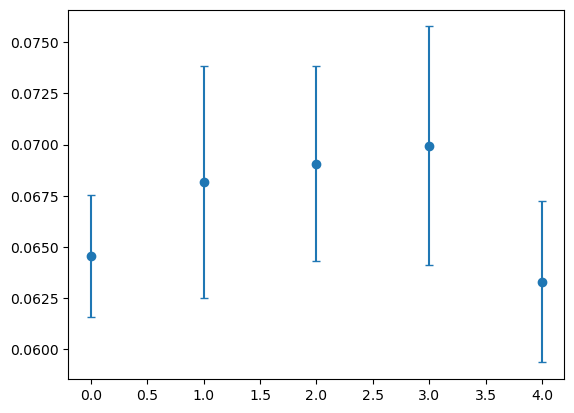

In [68]:
for i, (m, s) in enumerate(zip(solid_angle_mean, solid_angle_std)):
    print(f"SAMPLE {i:2d} Omega  = {m:.3f} ± {s:.3f}")

plt.figure()
plt.errorbar(range(N), solid_angle_mean, yerr=solid_angle_std, fmt="o", capsize=3, color="tab:blue")

plt.show()